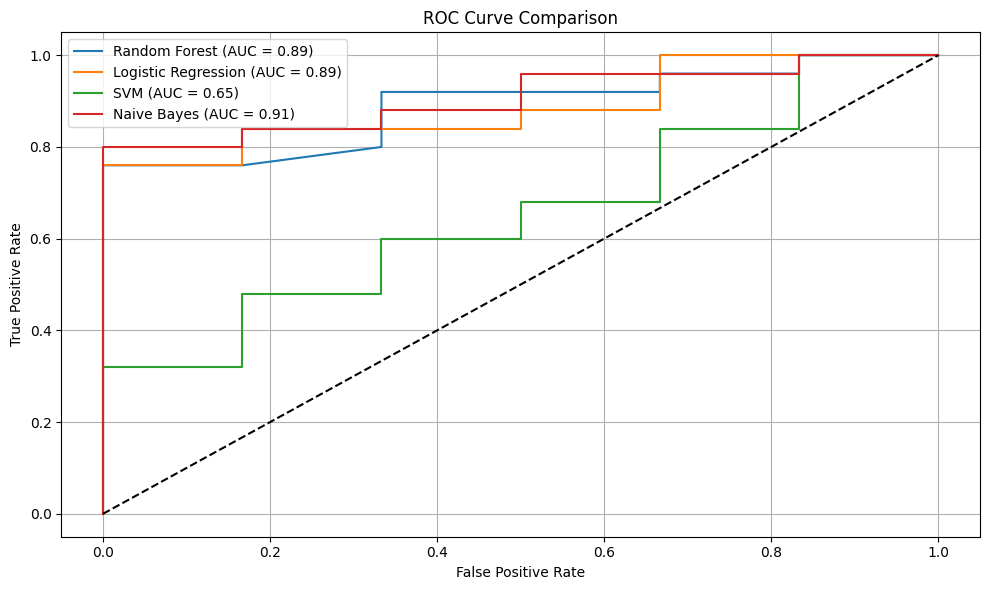

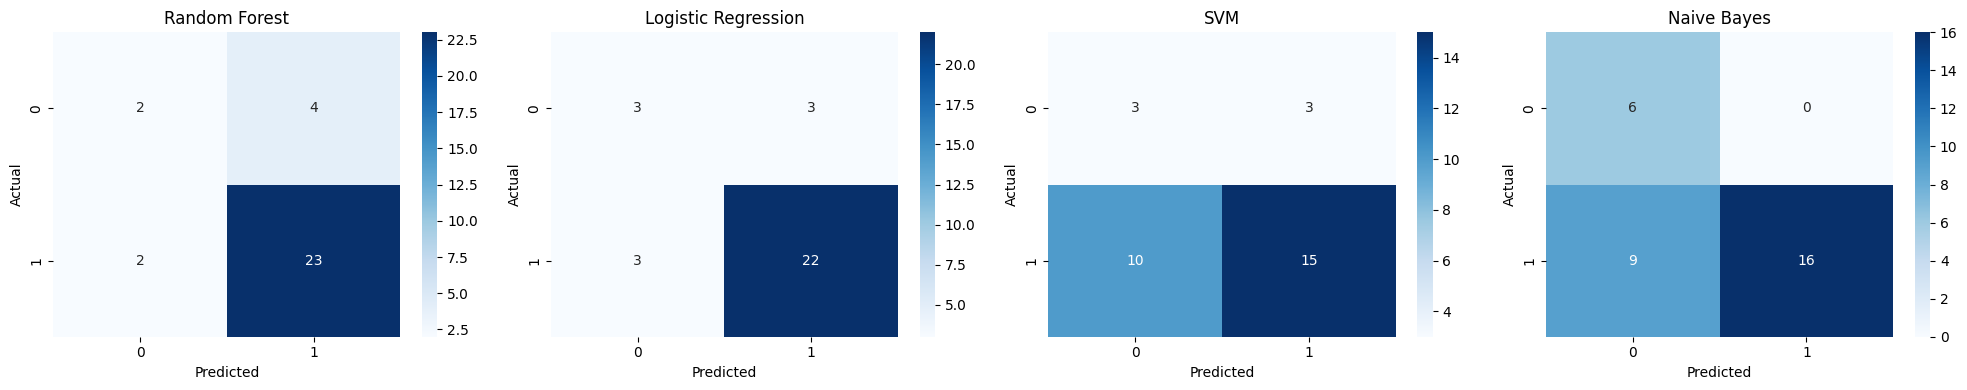

📊 Model Performance Summary:
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Random Forest            0.81       0.85    0.92      0.88     0.89
Logistic Regression      0.81       0.88    0.88      0.88     0.89
Naive Bayes              0.71       1.00    0.64      0.78     0.91
SVM                      0.58       0.83    0.60      0.70     0.65


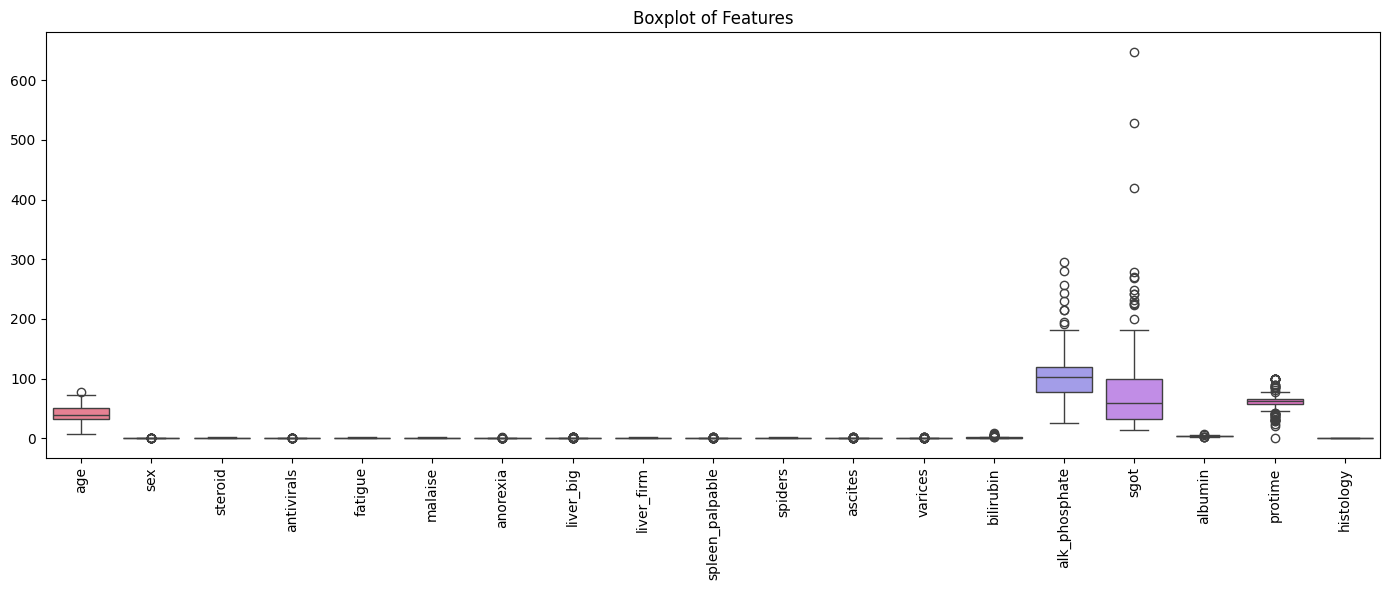

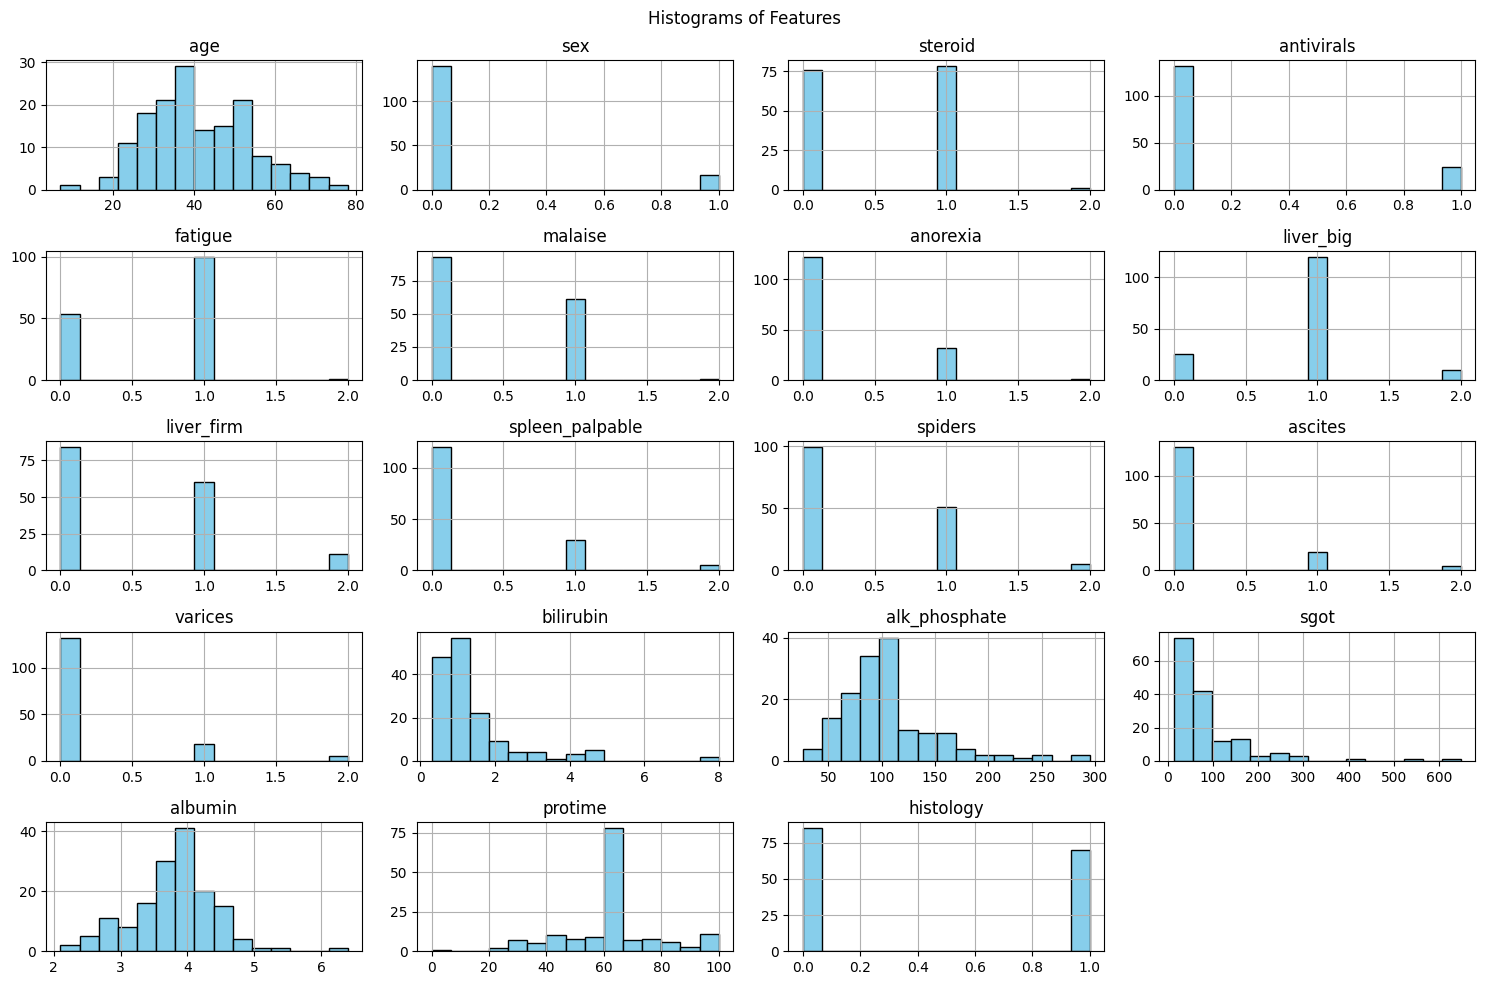

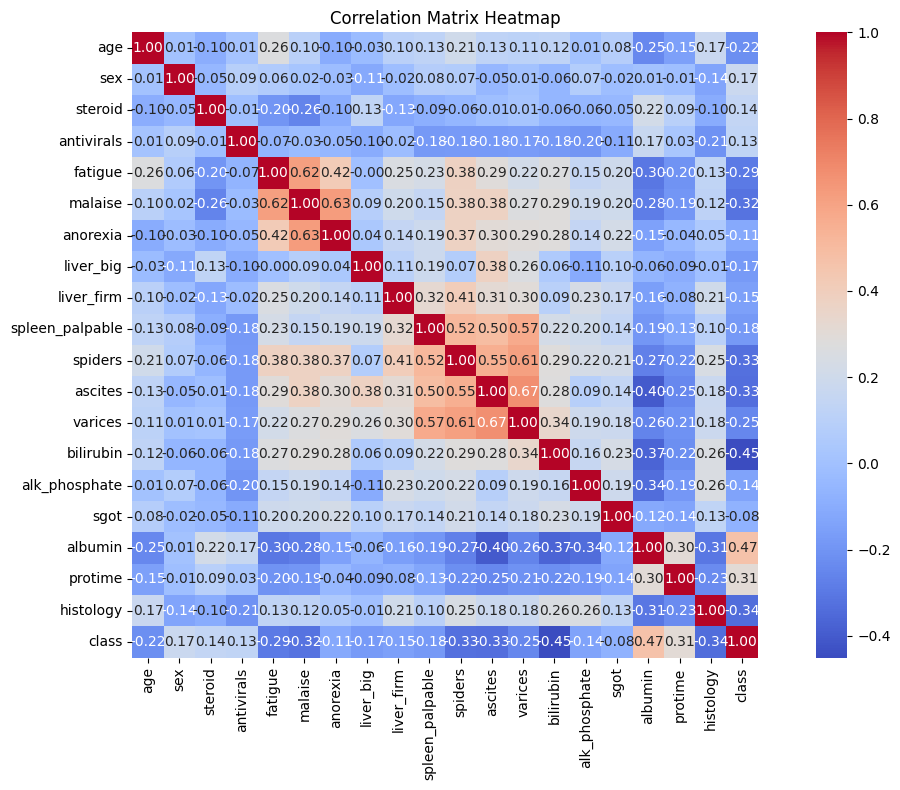

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


url = "/content/hepatitis_csv.csv"
df = pd.read_csv(url)


label_cols = df.select_dtypes(include='object').columns
df[label_cols] = df[label_cols].apply(LabelEncoder().fit_transform)


imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


X = df_imputed.drop('class', axis=1)
y = df_imputed['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}


results = {}
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results[name] = {
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "fpr": fpr,
        "tpr": tpr
    }


plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{name} (AUC = {res['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["conf_matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


summary_df = pd.DataFrame({
    name: {
        "Accuracy": res['accuracy'],
        "Precision": res['precision'],
        "Recall": res['recall'],
        "F1 Score": res['f1'],
        "ROC AUC": res['roc_auc']
    }
    for name, res in results.items()
}).T.round(2)

print("📊 Model Performance Summary:")
print(summary_df.sort_values(by="F1 Score", ascending=False))


plt.figure(figsize=(14, 6))
sns.boxplot(data=df_imputed.drop(columns=['class']))
plt.xticks(rotation=90)
plt.title('Boxplot of Features')
plt.tight_layout()
plt.show()


df_imputed.drop(columns=['class']).hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
corr_matrix = df_imputed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


In [2]:
import joblib
filename = 'hepatitis.sav'
joblib.dump(model, filename)


['hepatitis.sav']